In [ ]:
### test vivit using video data

In [9]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import torch

np.random.seed(0)

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

print(video.shape)

c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(32, 360, 640, 3)


In [10]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")


Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params: ,} || all params: {all_param: ,} || trainable%: {100 * trainable_params / all_param}"
    )

print(model.config)
print_trainable_parameters(model)
# image_processor

VivitConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vivit-b-16x2-kinetics400",
  "architectures": [
    "ViViTForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "L

In [8]:
model.config.hidden_size

768

In [4]:
video.shape

(32, 360, 640, 3)

In [4]:
import torch
inputs = image_processor(list(video), return_tensors="pt")
print(inputs['pixel_values'].shape)

processed_video = np.array(inputs['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_video.shape

torch.Size([1, 32, 3, 224, 224])


(32, 224, 224, 3)

In [5]:
import av
import cv2  # For visualization

# ... (your existing code for reading the video) ...

# Display the original video using OpenCV
for frame in video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file

# Display the original video using OpenCV
for frame in processed_video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file



ModuleNotFoundError: No module named 'cv2'

In [8]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(list(last_hidden_states.shape))
cls_representation = last_hidden_states[:, 0, :]
print(cls_representation.shape)

[1, 3137, 768]
torch.Size([1, 768])


In [ ]:
###  test using MD data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

In [3]:
import mdtraj as md
import numpy as np

# Load trajectory and topology
traj = md.load('./data/MD/1k5n_A_analysis/1k5n_A_R1.xtc', top='./data/MD/1k5n_A_analysis/1k5n_A.pdb')

# Compute contact maps for each frame using a distance cutoff (e.g., 0.45 nm)
cutoff = 7  # in nanometers
contact_maps = []
for frame in traj:
    # compute pairwise distances
    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA'))
    # generate contact map: 1 if distance < cutoff, else 0
    # contact_map = (distances < cutoff).astype(int)
    # contact_maps.append(contact_map)
    contact_maps.append(distances)

# Now contact_maps is a list of contact maps, one per frame.

In [4]:
# np.sum(contact_maps[1]>1)
print(len(contact_maps))
print(contact_maps[1].shape)

1001
(1, 37950)


In [11]:
# a=vector_to_contact_map(contact_maps[1].reshape(-1))
# np.expand_dims(a, axis=-1).shape

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

print(contact_maps[1].shape)

map_list=[]
for map in contact_maps:
    contact_map = vector_to_contact_map(map.reshape(-1))
    contact_map = np.expand_dims(contact_map, axis=-1)
    normalized_map = normalize_contact_map(contact_map)
    three_channel_map = np.repeat(normalized_map, 3, axis=-1) 
    map_list.append(three_channel_map)
    if len(map_list) == 32:
        break

print(map_list[0].shape)

input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False)
print(input_map['pixel_values'].shape)

(1, 37950)
(276, 276, 3)
torch.Size([1, 32, 3, 224, 224])


In [18]:
a=map_list[0][:100,:100,:]
print(a.shape)
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224, 224])
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False)
back=np.zeros((224,224,3))
back[:100,:100,:]=a
b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False, do_center_crop=False)
# b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224,224], do_center_crop=False)
c=b['pixel_values'][0,0,0]
print(c.shape)
d=a[:,:,0]
print(d.shape)
print(c)
print(d)

(100, 100, 3)
torch.Size([224, 224])
(100, 100)
tensor([[0.0000, 0.0614, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0614, 0.0000, 0.0601,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0601, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
[[0.         0.06137533 0.09999483 ... 0.3588073  0.32841434 0.27128245]
 [0.06137533 0.         0.06005734 ... 0.30704371 0.27689615 0.22155744]
 [0.09999483 0.06005734 0.         ... 0.25943856 0.2296494  0.17345286]
 ...
 [0.3588073  0.30704371 0.25943856 ... 0.         0.06111426 0.10914952]
 [0.32841434 0.27689615 0.2296494  ... 0.06111426 0.         0.05978399]
 [0.27128245 0.22155744 0.17345286 ... 0.10914952 0.05978399 0.        ]]


In [172]:
b['pixel_values'].shape

torch.Size([1, 1, 3, 224, 224])

In [161]:
res['attentions'][0].shape

torch.Size([1, 12, 3137, 3137])

In [59]:
print(input_map['pixel_values'].shape)

torch.Size([1, 32, 3, 224, 224])


In [198]:
# input_map.keys()
a = torch.concatenate((input_map['pixel_values'], input_map['pixel_values']), dim=0)
# # print(map['pixel_values'].shape)
a.shape

outputs=model(a)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
print(last_hidden_states[0,0:5,0:5])
print(last_hidden_states[1,0:5,0:5])

torch.Size([2, 3137, 768])
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)


In [17]:
map_list[0].shape

(276, 276, 3)

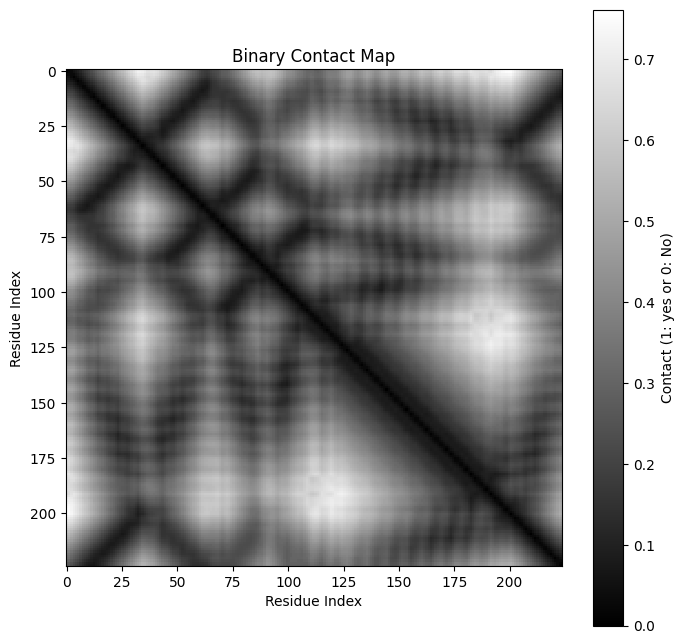

In [57]:


# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
# contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))
contact_map = map_list[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(c, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

In [ ]:
from Bio.PDB import PDBParser, PPBuilder

# Replace with your PDB file path
pdb_file = "./data/MD/dev_data/r1/1k5n_A.pdb"

# Create a PDB parser object
parser = PDBParser(QUIET=True)

# Parse the structure from the PDB file
structure = parser.get_structure("protein", pdb_file)

# Initialize the polypeptide builder
ppb = PPBuilder()

# Extract sequences from all chains in the structure
for model in structure:
    for chain in model:
        # Build polypeptides for the chain (could be more than one segment)
        polypeptides = ppb.build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides):
            sequence = poly.get_sequence()
            print(f"Chain {chain.id} (segment {poly_index}): {sequence}")

In [ ]:
### test vivit model

In [ ]:
from transformers import VivitModel
import torch
# model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="sdpa", torch_dtype=torch.float16)
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="")

OSError: google/vivit-b-16x2-kinetics600 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [36]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
print(map_list[0].shape)
input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**input_map)

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(276, 276, 3)


In [38]:
print(result.last_hidden_state.shape)

torch.Size([1, 3137, 768])


In [41]:
small_map_list=[map[0:100, 0:100, :] for map in map_list]
print(small_map_list[0].shape)
print(len(small_map_list))
small_input_map = image_processor(small_map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**small_input_map)

(100, 100, 3)
32


torch.Size([1, 32, 3, 224, 224])


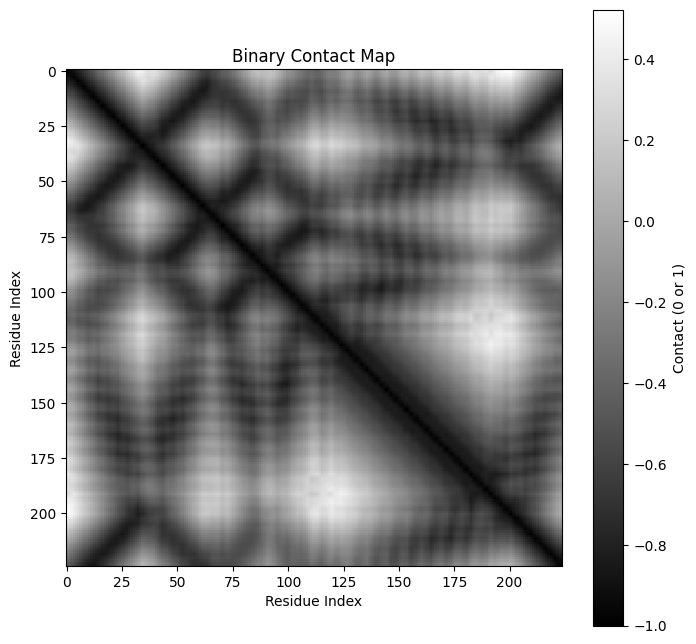

In [44]:
print(small_input_map['pixel_values'].shape)
processed_map = np.array(small_input_map['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_map.shape

contact_map = processed_map[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="Contact (0 or 1)")
plt.show()

In [ ]:
import torch
import os
import mdtraj as md
import numpy as np
import math
from Bio.PDB import PDBParser, PPBuilder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from transformers import VivitImageProcessor

class ProteinMDDataset(Dataset):
    def __init__(self, samples, configs,mode="train"):
        self.original_samples = samples
    def __len__(self):
           return len(self.original_samples)
    def __getitem__(self, idx):
        pid, seq, traj = self.original_samples[idx]
        return pid, seq, traj


def custom_collate(batch):
    pid, seq, trajs = zip(*batch)
    # Remove the extra dimension from each contact sample
    traj_list = [traj.squeeze(0) for traj in trajs]
    # Now each traj has shape [32, 3, 224, 224]
    # Stack them along a new first dimension (batch dimension)
    traj_batch = torch.stack(traj_list, dim=0)
    batched_data = {'pid': pid, 'seq': seq, 'traj': traj_batch}
    # return pid, seq, contacts
    return batched_data

def prepare_dataloaders(configs):
    samples = prepare_samples(configs.train_settings.Atlas_data_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    total_samples = len(samples)
    val_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    train_size = total_samples - val_size - test_size
    train_samples, val_samples, test_samples = random_split(samples, [train_size, val_size, test_size])

    samples_hard = prepare_samples(configs.train_settings.Atlas_test_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    hard_num = len(samples_hard)
    val_size = int(hard_num * 0.5)
    test_size = hard_num - val_size
    val_hard, test_hard = random_split(samples_hard, [val_size, test_size])
    val_samples = val_samples + val_hard
    test_samples = test_samples + test_hard


    print(f"train samples: {len(train_samples)}, val samples: {len(val_samples)}, test samples: {len(test_samples)}")
    # Create DataLoader for each split
    train_dataset = ProteinMDDataset(train_samples, configs=configs, mode="train")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=True,
        collate_fn=custom_collate,
        drop_last=False
    )

    val_dataset = ProteinMDDataset(val_samples, configs=configs, mode="val")
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    test_dataset = ProteinMDDataset(test_samples, configs=configs, mode="val")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    # dataset = ProteinMDDataset(samples, configs=configs, mode = "train")
    # dataloader = DataLoader(dataset, batch_size=configs.train_settings.batch_size, shuffle=True, collate_fn=custom_collate,drop_last=False)
    return train_dataloader, val_dataloader, test_dataloader



def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

def pdb2seq(pdb_path):
    # Create a PDB parser object
    parser = PDBParser(QUIET=True)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("protein", pdb_path)
    
    # Initialize the polypeptide builder
    ppb = PPBuilder()
    
    # Extract sequences from all chains in the structure
    for model in structure:
        for chain in model:
            # Build polypeptides for the chain (could be more than one segment)
            polypeptides = ppb.build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                sequence = poly.get_sequence()
                # print(f"Chain {chain.id} (segment {poly_index}): {sequence}")
    return sequence

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

def prepare_samples(data_folder2search, model_name, cache_path):
    image_processor = VivitImageProcessor.from_pretrained(model_name, cache_dir=cache_path)
    # Specify the parent folder (folder A)
    folder_A = data_folder2search
    samples = []
    
    # Iterate through each subfolder under folder_A
    data={}
    for subfolder in os.listdir(folder_A):
        subfolder_path = os.path.join(folder_A, subfolder)
        
        # Check if the path is a directory
        if os.path.isdir(subfolder_path):
            num_xtc=0
            num_pdb=0
            traj_files=[]

            for file_name in os.listdir(subfolder_path):
                if file_name.endswith(".xtc"):
                    file_xtc_path = os.path.join(subfolder_path, file_name)
                    traj_files.append(file_xtc_path)
                    # num_xtc += 1
                elif file_name.endswith(".pdb"):
                    file_pdb_path = os.path.join(subfolder_path, file_name)
                    pid = file_name.split(".")[0]
                    # num_pdb += 1
            sequence = pdb2seq(file_pdb_path)
            data[pid]={'ind2seq':{}, 'ind2map':{}}
            fragments, frag_contact = fragment_sequence(sequence, None, fixed_length=224, overlap=30)
            data_len=len(fragments)
            for i in range(data_len):
                data[pid]['ind2map'][i]=[]

            for file_xtc_path in traj_files:
                traj = md.load(file_xtc_path, top=file_pdb_path)
                # cutoff = 7  # in nanometers
                # contact_maps = []
                for frame in traj:
                    # compute pairwise distances
                    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA')) # [1, L] 
                    # generate contact map: 1 if distance < cutoff, else 0
                    # contact_map = (distances < cutoff).astype(int)
                    contact_map = vector_to_contact_map(distances.reshape(-1)) # [N, N]

                    fragments, frag_contact = fragment_sequence(sequence, contact_map, fixed_length=224, overlap=30)
                    for i in range(len(fragments)):
                        frag_seq=fragments[i]
                        contact_map=frag_contact[i]
                        contact_map = np.expand_dims(contact_map, axis=-1) # [N, N, 1]
                        normalized_map = normalize_contact_map(contact_map) # [N, N, 1]
                        three_channel_map = np.repeat(normalized_map, 3, axis=-1) # [N, N, 3]
                        data[pid]['ind2seq'][i]=frag_seq
                        data[pid]['ind2map'][i].append(three_channel_map)
                        # contact_maps.append(three_channel_map)

                for i in range(len(fragments)):
                    pid_i = pid+"_"+str(i)
                    seq_i = data[pid]['ind2seq'][i]
                    traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
                                           do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
                    input_traj = traj['pixel_values']
                    groups = group_frames(input_traj)
                    for j in groups:
                        samples.append((pid_i, seq_i, groups[j]))
                
    return samples

def fragment_sequence(sequence, contact_map, fixed_length, overlap):
    fragments = []
    frag_contact = []
    stride = fixed_length - overlap
    start = 0
    seq_len = len(sequence)
    while start < seq_len:
        end = min(start + fixed_length, seq_len)
        fragment = sequence[start:end]
        fragments.append(fragment)  # Add fragment *before* checking length
        if contact_map.size!=0:
            if end-start<fixed_length:
                background = np.zeros((contact_map.shape[0],224, 224))
                background[:,:end-start, :end-start] = contact_map[:,start:end, start:end]
                frag_contact.append(background)
            else:
                frag_contact.append(contact_map[:, start:end, start:end])
        if end == seq_len: #check if the end of the sequence has been reached
            break
        start += stride
    return fragments, frag_contact


def group_frames(traj, group_size=32):
    """
    Group frames into sets of specified size.
    
    Args:
        total_frames (int): Total number of frames
        group_size (int): Number of frames in each group
        
    Returns:
        list: List of lists, where each inner list is a group of frames
    """
    total_frames = traj.shape[1]
    groups = []
    
    # Calculate how many complete groups we'll have
    num_complete_groups = total_frames // group_size
    
    # Group the frames
    for i in range(num_complete_groups):
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = traj[:,start_idx:end_idx,:,:,:]
        groups.append(group)
    
    # Handle any remaining frames
    remaining_frames = total_frames % group_size
    if remaining_frames > 0:
        group = traj[:,total_frames-32:,:,:,:]
        groups.append(group)
    
    processed_arrays = [arr.squeeze(0) for arr in groups]  # shape becomes [32, 3, 224, 224]
    # Stack along a new axis (axis=0)
    result = torch.stack(processed_arrays, axis=0) # [list_len, 32, 3, 224, 224]
    return result

import psutil
import os

def get_memory_usage_gb():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    memory_usage_gb = mem_info.rss / (1024 ** 3)  # 转换为 GB
    return memory_usage_gb

In [134]:
import subprocess
def get_gpu_usage_smi():
    result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', '--format=csv,noheader,nounits'], 
                            stdout=subprocess.PIPE, text=True)
    lines = result.stdout.strip().split('\n')
    usage_info = []
    for i, line in enumerate(lines):
        gpu_util, mem_used, mem_total = line.split(', ')
        usage_info.append({
            'gpu_index': i,
            'gpu_utilization_percent': int(gpu_util),
            'memory_used_MB': int(mem_used),
            'memory_total_MB': int(mem_total),
        })
    return usage_info

usage = get_gpu_usage_smi()
for gpu in usage:
        print(f"GPU {gpu['gpu_index']}:")
        print(f"  GPU Utilization: {gpu['gpu_utilization_percent']}%")
        print(f"  Memory Used: {gpu['memory_used_MB']} MB")
        print(f"  Memory Total: {gpu['memory_total_MB']} MB")

GPU 0:
  GPU Utilization: 10%
  Memory Used: 2057 MB
  Memory Total: 11264 MB


In [ ]:
def vectors_to_contact_maps(vecs):
    """
    Converts multiple vectors of pairwise contact values into symmetric contact map matrices.
    
    Args:
        vecs (np.ndarray): 2D array of shape (n, L),
                           where L = N*(N-1)/2 and n is number of vectors.
    
    Returns:
        contact_maps (np.ndarray): 3D array of shape (n, N, N).
    """
    n, num_pairs = vecs.shape
    # 计算N
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # 初始化输出数组
    contact_maps = np.zeros((n, N, N), dtype=vecs.dtype)
    
    # 获取上三角索引（不包括对角线）
    triu_indices = np.triu_indices(N, k=1)
    
    # 给所有矩阵的上三角赋值
    contact_maps[:, triu_indices[0], triu_indices[1]] = vecs
    
    # 镜像到下三角，使矩阵对称
    contact_maps = contact_maps + np.transpose(contact_maps, (0, 2, 1))
    
    return contact_maps

data_folder2search='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_data/'
model_name='google/vivit-b-16x2-kinetics400'
list_num=0
output_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_data'

import numpy as np
from transformers import VivitImageProcessor, VivitModel
import torch

image_processor = VivitImageProcessor.from_pretrained(model_name)
model = VivitModel.from_pretrained(model_name)
# Specify the parent folder (folder A)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VivitModel.from_pretrained(model_name).to(device)
folder_A = data_folder2search
samples = []

# Iterate through each subfolder under folder_A
#data={}
# for subfolder in os.listdir(folder_A):
subfolder = os.listdir(folder_A)[0]

subfolder = '2ysk_A'
subfolder = '4oj6_C'
subfolder_path = os.path.abspath(os.path.join(folder_A, subfolder))

# Check if the path is a directory
# if os.path.isdir(subfolder_path) and subfolder_path in sub_list:
traj_files=[]
for file_name in os.listdir(subfolder_path):
    if file_name.endswith(".xtc"):
        file_xtc_path = os.path.join(subfolder_path, file_name)
        traj_files.append(file_xtc_path)
        # num_xtc += 1
    elif file_name.endswith(".pdb"):
        file_pdb_path = os.path.join(subfolder_path, file_name)
        pid = file_name.split(".")[0]

    # num_pdb += 1
sequence = pdb2seq(file_pdb_path)
#fragments, frag_contact = fragment_sequence(sequence, np.array([]), fixed_length=224, overlap=30)
#data_len=len(fragments)
rep=0

file_xtc_path = traj_files[0]
#data[pid]={'ind2seq':{}, 'ind2map':{}}
#for i in range(data_len):
#     data[pid]['ind2map'][i]=[]
traj = md.load(file_xtc_path, top=file_pdb_path)
# cutoff = 7  # in nanometers
# contact_maps = []
distances = md.compute_distances(traj, traj.topology.select_pairs('name CA', 'name CA'))
contact_maps = vectors_to_contact_maps(distances) # [n, N, N]
fragments, frag_contacts = fragment_sequence(sequence, contact_maps, fixed_length=224, overlap=30)
# for i in range(len(fragments)):
i=0
frag_seq=fragments[i]
frag_contact=frag_contacts[i]
frag_contact = np.expand_dims(frag_contact, axis=-1) # [n, N, N, 1]
frag_contact = normalize_contact_map(frag_contact) # [n, N, N, 1]
frag_contact = np.repeat(frag_contact, 3, axis=-1) # [n, N, N, 3]
#data[pid]['ind2seq'][i]=frag_seq
#data[pid]['ind2map'][i]=frag_contact
#fo i in range(len(fragments)):
pid_i = pid+"#frag"+str(i)
h5id = pid_i+"#rep"+str(rep)
#seq_i = data[pid]['ind2seq'][i]
seq_i = frag_seq
# traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
#                        do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
images = image_processor(list(frag_contact), return_tensors="pt", do_rescale=False, offset=False, 
                       do_normalize=False, do_resize=False) # [1, 1000, 3, 224, 224]
images = images['pixel_values']
groups = group_frames(images)
groups = groups.to(device)
sub_num=groups.shape[0]//8
sub_remain=groups.shape[0]%8
rep_list=[]
print(get_memory_usage_gb())
for z in range(sub_num):
    print(z)
    sub_groups = groups[z*8:z*8+8]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    # sub_list.append(cls_representation)
    rep_list.append(cls_representation.detach().cpu())
    print(get_memory_usage_gb())

if sub_remain!=0:
    sub_groups = groups[-sub_remain:]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    rep_list.append(cls_representation.detach().cpu())

cls_representation = torch.cat(rep_list, dim=0) #[list_len, 1, 768]
pooled = cls_representation.mean(axis=0)  # shape: (768,)
del rep_list, images, groups, frag_contact
# samples.append((h5id, pid_i, seq_i, pooled))
saveh5((pid_i, seq_i, pooled), os.path.join(output_folder, h5id+".h5"))

In [ ]:
process_files=[]
process_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_test/'
for file_name in os.listdir(process_folder):
    if file_name.split('#')[0] in process_files:
        continue
    else:
        process_files.append(file_name.split('#')[0])

data_files=[]
data_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_test/'
for file_name in os.listdir(data_folder):
    data_files.append(file_name)

print(len(process_files), len(data_files))


In [ ]:
# labels = torch.cat([torch.arange(batch_size, device=accelerator.device) for i in range(n_views)], dim=0)
# labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(accelerator.device)



In [35]:
labels = torch.cat([torch.arange(3) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels

tensor([0, 1, 0, 2, 0, 1, 0, 2])

In [ ]:
import torch
# labels = torch.cat([torch.arange(4) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

labels


tensor([[1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])

In [38]:
import torch.nn.functional as F
features_struct=torch.rand(4,7)
features_seq=torch.rand(4,7)
features_struct = F.normalize(features_struct, dim=1)
features_seq = F.normalize(features_seq, dim=1)
features = torch.cat([features_struct, features_seq], dim=0)
similarity_matrix = torch.matmul(features, features.T)
similarity_matrix

tensor([[1.0000, 0.4727, 0.8975, 0.7695, 0.7408, 0.7446, 0.6329, 0.6612],
        [0.4727, 1.0000, 0.6748, 0.7332, 0.8421, 0.7428, 0.8604, 0.8967],
        [0.8975, 0.6748, 1.0000, 0.8639, 0.7770, 0.8605, 0.6755, 0.8038],
        [0.7695, 0.7332, 0.8639, 1.0000, 0.9102, 0.7454, 0.7854, 0.7651],
        [0.7408, 0.8421, 0.7770, 0.9102, 1.0000, 0.7026, 0.8573, 0.8185],
        [0.7446, 0.7428, 0.8605, 0.7454, 0.7026, 1.0000, 0.7178, 0.9403],
        [0.6329, 0.8604, 0.6755, 0.7854, 0.8573, 0.7178, 1.0000, 0.7757],
        [0.6612, 0.8967, 0.8038, 0.7651, 0.8185, 0.9403, 0.7757, 1.0000]])

In [27]:
mask = torch.eye(labels.shape[0], dtype=torch.bool)
print(mask)
labels = labels[~mask].view(labels.shape[0], -1)
print(labels)
similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
similarity_matrix

tensor([[ True, False, False, False, False, False],
        [False,  True, False, False, False, False],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False,  True, False],
        [False, False, False, False, False,  True]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


tensor([[0.5466, 0.5666, 0.9298, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.7429, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277, 0.7414],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.7429, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.7414, 0.3900, 0.7283]])

In [28]:
positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)


In [30]:
negatives

tensor([[0.5466, 0.5666, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277],
        [0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.3900, 0.7283]])

In [32]:
logits = torch.cat([positives, negatives], dim=1)
labels = torch.zeros(logits.shape[0], dtype=torch.long)


In [33]:
logits

tensor([[0.9298, 0.5466, 0.5666, 0.7817, 0.4387],
        [0.7429, 0.5466, 0.7536, 0.5639, 0.9340],
        [0.7414, 0.5666, 0.7536, 0.5439, 0.9277],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7429, 0.7817, 0.9277, 0.6863, 0.7283],
        [0.7414, 0.4387, 0.9340, 0.3900, 0.7283]])

In [34]:
labels

tensor([0, 0, 0, 0, 0, 0])

In [40]:
import esm_adapterH
from box import Box
config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
config = Box(config)
config.enable
esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)
batch_converter = alphabet.get_batch_converter(truncation_seq_length=200)
seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTWNSSEVGCDFPPNSDTLYCKEWPNCATNPSVHCPCLMCMLKLRHRNRKFLRSSPLVWIDCYCFDCFRQWFGCDLTQEALHCWEKVLGDTPYRDLKL'
seq2='MSKNKDQRTAKTLERTWDTLNHLLFISSCLYKLNLKSVAQITLSILAMIISTSLIIAAIIFIASANHKVTPT\
    TAIIQDATSQIKNTTPTYLTQNPQLGISPSNPSEITSQITTILASTTPGVKSTLQSTTVKTKNTTTTQTQPSKPT\
        TKQRQNKPPSKPNNDFHFEVFNFVPCSICSNNPTCWAICKRIPNKKPGKKTTTKPTKKPTLKTTKKDPKPQTTKSKEVPTTKPTEEPTINTTK\
            TNIITTLLTSNTTGNPELTSQMETFHSTSSEGNPSPSQVSTTSEYPSQPSSPPNTPRQ'


In [94]:
alphabet.all_toks

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [118]:
# batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1), ('seq2',seq2)])
batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1)])
outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)


In [119]:
outputs.keys()
mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
                    batch_tokens != alphabet.eos_idx))
residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]

In [124]:
residue_feature_embedding.shape

torch.Size([172, 640])

In [123]:
print(mask.shape)
mask

torch.Size([1, 174])


tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [111]:
outputs['representations'][esm2.num_layers].shape

torch.Size([2, 202, 640])

In [89]:
outputs['logits'][0,:5,:]

tensor([[ 19.3523,  -5.0466,   4.7599,  -4.9001,  -1.6688,  -0.9734,   0.1751,
          -0.9683,   0.2612,  -0.1574,   1.3448,  -1.7355,  -0.2613,  -0.3624,
          -1.3045,   1.0823,  -0.9245,   0.3088,  -2.7846,  -1.6144,   2.6701,
          -2.2198,  -2.5766,  -2.1414,  -6.8320,  -8.9827, -12.3936, -10.7671,
         -16.3860, -15.9422, -15.4255, -17.0992,  -4.9094],
        [ -5.8481, -10.2043,  -7.6505, -10.1891,   0.1361,  -1.2317,  -0.7126,
          -0.3726,  -0.9468,  -0.5091,  -0.5760,  -1.5764,  -0.0470,  -0.5554,
          -1.2230,   0.1814,  -1.3063,  -0.8021,  -1.1079,  -1.2042,  10.5108,
          -2.0586,  -1.2919,  -2.0041,  -2.9631,  -9.6436, -10.1475, -10.5877,
         -16.1790, -15.7093, -15.0280, -16.3700, -10.2238],
        [-10.8190, -15.6347, -10.4180, -15.6570,  -0.5078,   0.0263,   0.0419,
          -0.4917,   0.2347,   0.5237,  -0.1507,  -0.3582,  -0.7710,   3.5694,
          -1.1319,   0.6411,  -1.0973,  -0.2083,  -1.3865,  -1.0799,  -0.8308,
          -

In [100]:
# np.log(outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy())
# outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy()
log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
log_soft[0,:5,:]

tensor([[1.0000e+00, 2.5334e-11, 4.5987e-07, 2.9333e-11, 7.4243e-10, 1.4882e-09,
         4.6930e-09, 1.4959e-09, 5.1152e-09, 3.3656e-09, 1.5117e-08, 6.9454e-10,
         3.0333e-09, 2.7417e-09, 1.0688e-09, 1.1627e-08, 1.5629e-09, 5.3646e-09,
         2.4326e-10, 7.8392e-10, 5.6889e-08, 4.2794e-10, 2.9951e-10, 4.6284e-10,
         4.2492e-12, 4.9463e-13, 1.6328e-14, 8.3046e-14, 3.0134e-16, 4.6970e-16,
         7.8745e-16, 1.4768e-16, 2.9061e-11],
        [7.8579e-08, 1.0079e-09, 1.2958e-08, 1.0233e-09, 3.1204e-05, 7.9463e-06,
         1.3354e-05, 1.8762e-05, 1.0566e-05, 1.6369e-05, 1.5308e-05, 5.6295e-06,
         2.5982e-05, 1.5628e-05, 8.0161e-06, 3.2650e-05, 7.3753e-06, 1.2211e-05,
         8.9939e-06, 8.1681e-06, 9.9975e-01, 3.4760e-06, 7.4824e-06, 3.6704e-06,
         1.4069e-06, 1.7659e-09, 1.0668e-09, 6.8698e-10, 2.5625e-12, 4.0988e-12,
         8.1008e-12, 2.1170e-12, 9.8852e-10],
        [4.1068e-07, 3.3270e-09, 6.1326e-07, 3.2536e-09, 1.2348e-02, 2.1065e-02,
         2.1396e-

In [43]:
import mdtraj as md
import numpy as np
traj = md.load("./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb")

In [83]:
traj

<mdtraj.Trajectory with 5000 frames, 73 atoms, 73 residues, and unitcells at 0x2275b91fdf0>

In [87]:
three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}
sequence = ""
for residue in traj.topology.residues:
        sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

print(sequence)
len(sequence)

KPGARSSGVYNINSWRSNRRSLVHQRPSREIRKELLNYQISEDELSFDSAAGLASGMKFDSARGMGVTSIILT


73

In [ ]:
n_residues = traj.topology.n_residues
rmsf = np.zeros(n_residues)
avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_frames, n_atoms, 3)

In [64]:
traj.xyz.shape

(5000, 73, 3)

In [73]:
residue = next(traj.topology.residues)
i=0
atoms = residue.atoms
atom_indices = [atom.index for atom in atoms]
atom_indices
atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)
print(atom_positions.shape)
print(avg_positions[i, :].shape)
deviations = atom_positions - avg_positions[i, :]
print(deviations.shape)

(5000, 3)
(3,)
(5000, 3)


In [75]:
np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

0.27866495

In [185]:
import mdtraj as md
import numpy as np

three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}


sequence

def calculate_rmsf_from_pdb(pdb_file):
    """
    Calculate RMSF for each residue in a PDB file with multiple models (conformations).
    
    Args:
        pdb_file (str): Path to the PDB file containing multiple models (frames).
    
    Returns:
        rmsf (np.ndarray): RMSF values for each residue.
    """
    # Load the PDB file with multiple models (frames)
    traj = md.load(pdb_file)

    # sequence = ""
    # for residue in traj.topology.residues:
    #         sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

    # Calculate the number of residues and atoms
    n_residues = traj.topology.n_residues

    # Initialize a list to store RMSF for each residue
    rmsf = np.zeros(n_residues)

    # Calculate the average positions of each residue (CA atom positions)
    avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

    # Loop through each residue and calculate RMSF
    for i, residue in enumerate(traj.topology.residues):
        # Select all atoms of the residue (typically just the CA atom)
        atoms = residue.atoms
        atom_indices = [atom.index for atom in atoms]

        # Extract the positions for these atoms over all frames
        atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)

        # Calculate the deviation from the average position
        deviations = atom_positions - avg_positions[i, :]

        # Compute RMSF for the residue (mean squared deviations)
        rmsf[i] = np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

    return np.mean(rmsf)

# Example usage
# pdb_file = "./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb"  # PDB file with multiple models (frames)

# rmsf_values = calculate_rmsf_from_pdb(pdb_file)
# print(rmsf_values)


In [186]:
import os
import esm_adapterH
from box import Box
import esm

# config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
# config = Box(config)
# config.enable
# esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)

esm2, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()




# seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTW
file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}

seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'

folder_path = './NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/'
ddg_list=[]
emb_rmsf_list=[]
emb_esm2_list=[]
for file in os.listdir(folder_path):
    basename = file[:-4]
    file_path = os.path.join(folder_path, file)
    if basename in file2ddg.keys():
        ddg = file2ddg[basename]
    else:
        continue
    
    rmsf= calculate_rmsf_from_pdb(file_path)

    mut_ind = int(basename[1:-1])
    mut_AA = basename[-1]
    seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]

    batch_labels, batch_strs, batch_tokens = batch_converter([(basename, seq_mut)])
    outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
    # mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
    #                 batch_tokens != alphabet.eos_idx))
    # residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]
    cls_embedding = outputs['representations'][esm2.num_layers][0][0]

    emb_rmsf = np.concatenate((cls_embedding.detach().numpy(), rmsf.reshape(-1)))
    emb_esm2 = cls_embedding.detach().numpy()

    ddg_list.append(ddg)
    emb_rmsf_list.append(emb_rmsf)
    emb_esm2_list.append(emb_esm2)

    # print(basename)
    # print(file_path)

In [190]:
emb_rmsf_list[0].reshape(1,-1).shape

(1, 641)

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1))
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1))
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)

19 19 19


In [199]:
emb_rmsf_list[i][-1]

0.13991823195390504

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1)).item()
    # cosine_simi_rmsf = emb_rmsf_list[i][-1]-emb_rmsf_list[0][-1]
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1)).item()
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)



19 19 19


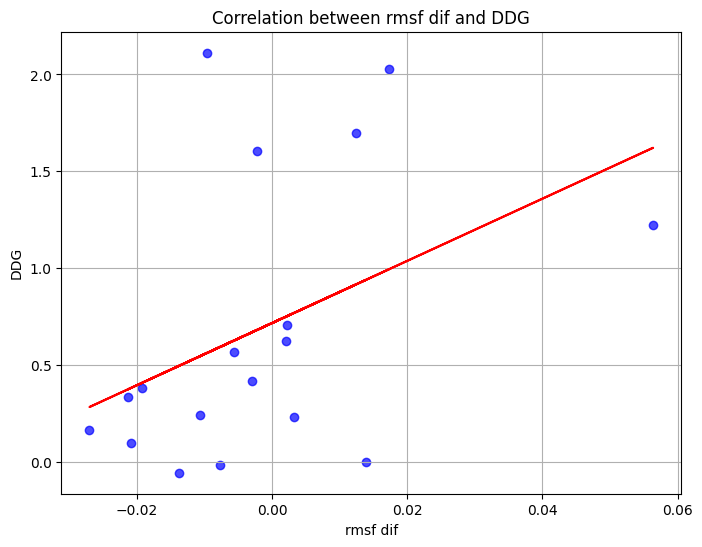

In [212]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

# Plot the fitted line
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.figure(figsize=(8, 6))
plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel('rmsf dif')
plt.ylabel('DDG')
plt.title('Correlation between rmsf dif and DDG')
plt.grid(True)
plt.show()

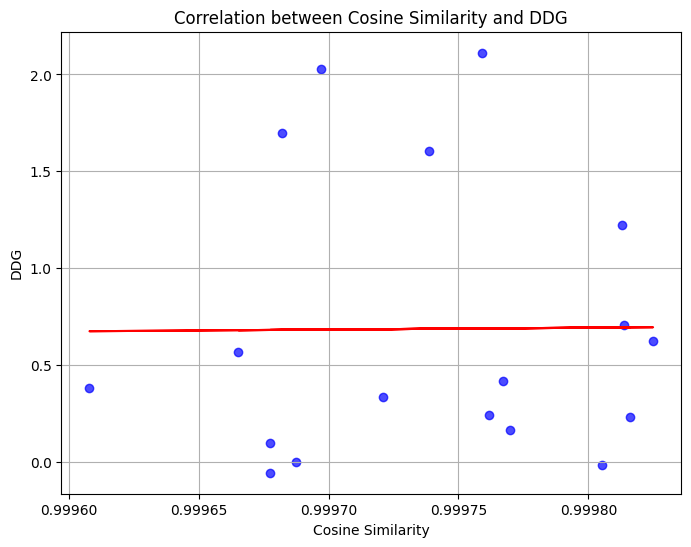

In [234]:
slope, intercept = np.polyfit(result_esm2, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_esm2) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_esm2, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_esm2, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [230]:
result_rmsf[0].item()

0.9998136986298869

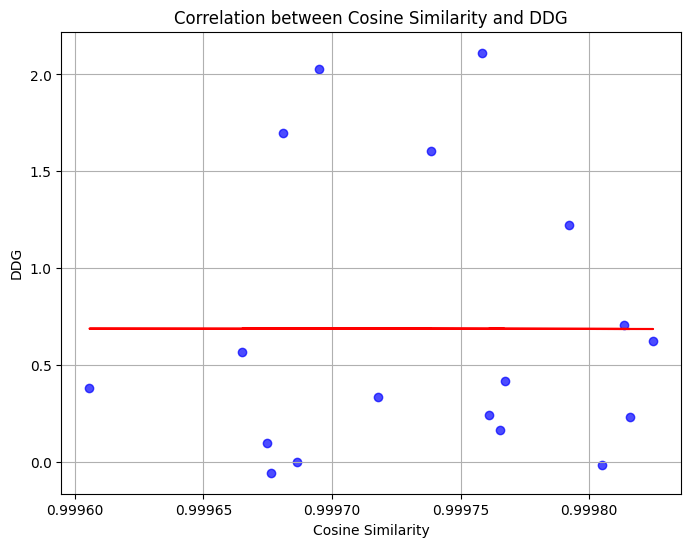

In [235]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [164]:
cls_embedding = outputs['representations'][esm2.num_layers][0][0]




In [174]:
np.concatenate((cls_embedding.detach().numpy(), np.mean(rmsf).reshape(-1)))

array([-7.19246641e-02,  9.71741825e-02, -3.75479460e-03,  9.34580863e-02,
       -3.29132229e-01,  1.70724168e-02, -3.87391746e-02,  1.77973602e-02,
       -1.67449996e-01,  2.14350030e-01, -1.22891240e-01, -1.59355830e-02,
        2.02257499e-01, -6.46229237e-02,  8.61120299e-02,  1.14054814e-01,
        7.88616948e-03,  2.11822942e-01, -3.45274955e-02, -6.27737194e-02,
        4.35790308e-02,  1.03383258e-01,  7.93840885e-02, -4.86047529e-02,
       -1.14475593e-01, -1.15044050e-01,  1.54253483e-01, -3.20821963e-02,
       -1.23469800e-01, -4.72468704e-01, -8.77034292e-02,  2.01518849e-01,
       -9.66207497e-03, -1.09536022e-01, -1.67476758e-01,  2.66932230e-02,
       -2.34791085e-01, -4.88679409e-02,  2.74616592e-02,  6.87071234e-02,
       -1.00635894e-01,  2.02421650e-01, -1.45571977e-02, -2.70459414e-01,
       -1.73112750e-01, -1.01115353e-01, -5.29978387e-02, -1.09264858e-01,
       -1.03434384e-01,  1.45304710e-01,  1.36497309e-02, -1.02263995e-01,
       -1.11902570e-02, -

In [170]:
np.mean(rmsf)

0.12268148204439307

In [ ]:
import yaml
from utils.utils import load_configs, load_checkpoints_md, get_logging
from accelerate import Accelerator, DistributedDataParallelKwargs
from model import prepare_models
from inspect import signature
import esm

config_path = "./configs/representation_config.yaml"
result_path = ''
with open(config_path) as file:
    dict_config = yaml.full_load(file)

configs = load_configs(dict_config)

accelerator = Accelerator()

logging = get_logging(result_path)
simclr = prepare_models(logging, configs, accelerator)
simclr = load_checkpoints_md(simclr, configs, 
                             resume_path='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/test2/checkpoints/checkpoint_0030000.pth')
    
alphabet = simclr.model_seq.alphabet
batch_converter = alphabet.get_batch_converter(truncation_seq_length=configs.model.esm_encoder.max_length)

scores_vivit, file2ddg = evaluate_with_nri(
    accelerator=accelerator,
    model=simclr,
    batch_converter=batch_converter,
    alphabet=alphabet   
)

esm2, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
scores_esm2, file2ddg = evaluate_esm2_nri(
    accelerator=accelerator,
    model=esm2,
    batch_converter=batch_converter,
    alphabet=alphabet  

)

list_vivit=[]
list_esm2=[]
ddt=[]
for key in file2ddg.keys():
    list_vivit.append(scores_vivit[key])
    list_esm2.append(scores_esm2[key])
    ddt.append(file2ddg[key]-(-1.565))


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_vivit, ddt, label="dplm mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('dplm mut effct')
plt.ylabel('DDG')
plt.title('Correlation between dplm mut effct and DDG')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_esm2, ddt, label="esm2 mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('esm2 mut effct')
plt.ylabel('DDG')
plt.title('Correlation between esm2 mut effct and DDG')
plt.grid(True)
plt.s

correlation_dplm = np.corrcoef(list_vivit, ddt)[0, 1]
correlation_esm2 = np.corrcoef(list_esm2, ddt)[0, 1]
print(f'correlation dplm: {correlation_dplm}\ncorrelation esm2: {correlation_esm2}')

In [ ]:
def evaluate_with_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            model_signature = signature(model.forward)
            if 'batch_tokens' in model_signature.parameters:
                logits  = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            else:
                logits  = model(batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            
            log_soft = torch.nn.functional.softmax(logits, dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg


def evaluate_esm2_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            outputs = model(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
            
            log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg











    seq_embeddings = []
    input = open(cathpath)
    labels = []
    seqs = []
    for line in input:
        labels.append(line[1:].split("|")[0].strip())
        line = next(input)
        seqs.append(line.strip())
    
    from torch.utils.data import DataLoader, Dataset
    
    class DataSet(Dataset):
        def __init__(self, pad_seq):
            self.pad_seq = pad_seq
        
        def __len__(self):
            return len(self.pad_seq)
        
        def __getitem__(self, index):
            return index, self.pad_seq[index]
    
    dataset_val = DataSet(seqs)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=0, pin_memory=False, drop_last=False)
    # val_loader = accelerator.prepare(val_loader)
    
    # model_prepresent.eval()
    for batch in val_loader:
        batch_seq = [(batch[0][i].item(), str(batch[1][i])) for i in range(len(batch[0]))]
        with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            batch_tokens = batch_tokens.to(accelerator.device)
            model_signature = signature(model.forward)
            if 'batch_tokens' in model_signature.parameters:
                _, _, features_seq, _  = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True)
            else:
                _, _, features_seq, _  = model(batch_tokens, mode='sequence', return_embedding=True)
            
            seq_embeddings.extend(features_seq.cpu().detach().numpy())
    
    seq_embeddings = np.asarray(seq_embeddings)
    mdel = TSNE(n_components=2, random_state=0, init='random',method='exact')
    # print("Projecting to 2D by TSNE\n")
    z_tsne_seq = mdel.fit_transform(seq_embeddings)
    scores = []
    tol_archi_seq = {"3.30", "3.40", "1.10", "3.10", "2.60"}
    tol_fold_seq = {"1.10.10", "3.30.70", "2.60.40", "2.60.120", "3.40.50"}
    
    for digit_num in [1, 2, 3]:  # first number of digits
        color = []
        colorid = []
        keys = {}
        colorindex = 0
        if digit_num == 1:
            ct = ["blue", "red", "black", "yellow", "orange", "green", "olive", "gray", "magenta", "hotpink", "pink",
                  "cyan", "peru", "darkgray", "slategray", "gold"]
        else:
            ct = ["black", "yellow", "orange", "green", "olive", "gray", "magenta", "hotpink", "pink", "cyan", "peru",
                  "darkgray", "slategray", "gold"]
        
        select_label = []
        select_index = []
        color_dict = {}
        for label in labels:
            key = ".".join([x for x in label.split(".")[0:digit_num]])
            if digit_num == 2:
                if key not in tol_archi_seq:
                    continue
            if digit_num == 3:
                if key not in tol_fold_seq:
                    continue
            
            if key not in keys:
                keys[key] = colorindex
                colorindex += 1
            
            select_label.append(keys[key])
            color.append(ct[(keys[key]) % len(ct)])
            colorid.append(keys[key])
            select_index.append(labels.index(label))
            color_dict[keys[key]] = ct[keys[key]]
        
        scores.append(calinski_harabasz_score(seq_embeddings[select_index], color))
        scores.append(calinski_harabasz_score(z_tsne_seq[select_index], color))
        scatter_labeled_z(z_tsne_seq[select_index], color,
                          filename=os.path.join(out_figure_path, f"step_{steps}_CATH_{digit_num}.png"))
        # add kmeans
        kmeans = KMeans(n_clusters=len(color_dict), random_state=42)
        predicted_labels = kmeans.fit_predict(z_tsne_seq[select_index])
        predicted_colors = [color_dict[label] for label in predicted_labels]
        #scatter_labeled_z(z_tsne_seq[select_index], predicted_colors,
        #                  filename=os.path.join(out_figure_path, f"step_{steps}_CATH_{digit_num}_kmpred.png"))
        ari = adjusted_rand_score(colorid, predicted_labels)
        scores.append(ari)
        scores.append(silhouette_score(seq_embeddings[select_index], color))
    return scores  # [digit_num1_full,digit_num_2d,digit_num2_full,digit_num2_2d]